In [1]:
import json
import os
import numpy as np
import librosa
import librosa.display
import soundfile as sf
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import Audio

In [2]:
vgg_wav_path = "/blob/v-yuancwang/DiffAudioImg/VGGSound/data/vggsound/wav"
vgg_mel_path = "/blob/v-yuancwang/DiffAudioImg/VGGSound/data/vggsound/mel"

In [ ]:
mel_id = "--EquRwM9IQ_8000_18000.npy"
test_mel = np.load(os.path.join(vgg_mel_path, mel_id))

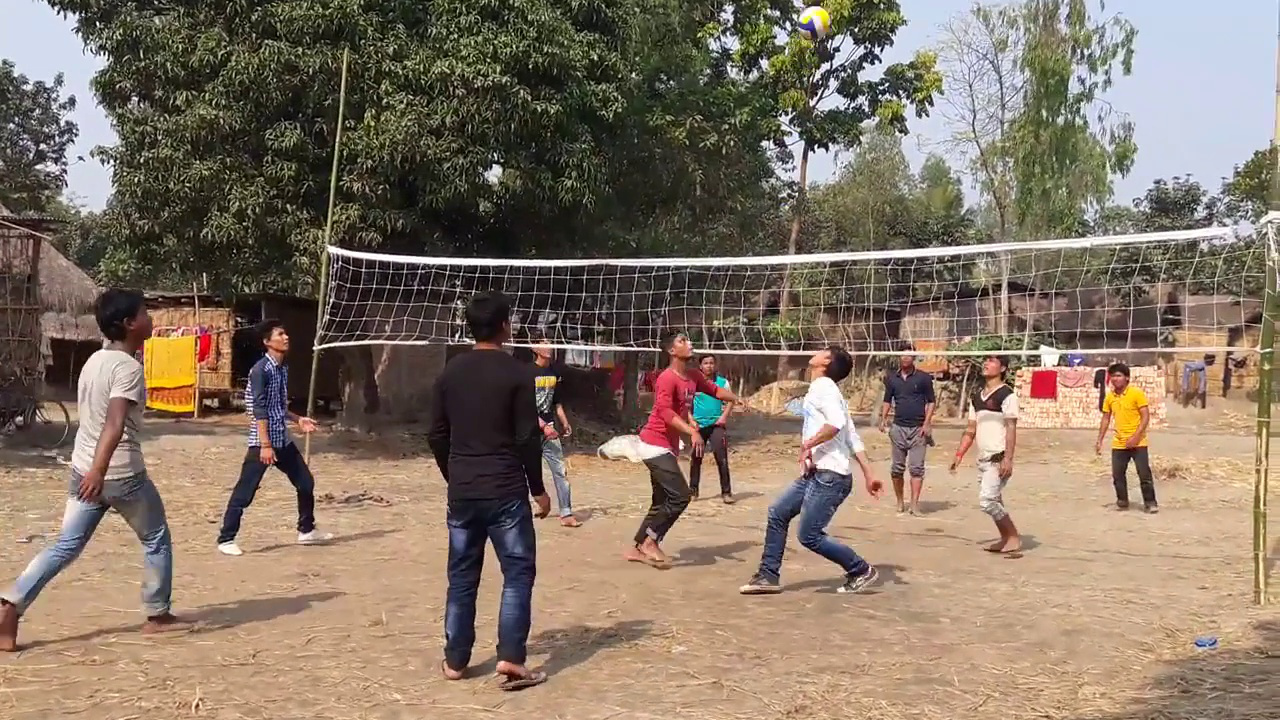

In [29]:
img_id = "2/--EquRwM9IQ_8000_18000_2.jpg"
image = Image.open(os.path.join("/blob/v-yuancwang/DiffAudioImg/VGGSound/data/vggsound/img_spilt", img_id))
image

In [30]:
wav_id = mel_id.replace(".npy", ".wav")
Audio(os.path.join(vgg_wav_path, wav_id))

In [31]:
import argparse
import logging
import math
import os
import random
from pathlib import Path
from typing import Optional

import accelerate
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from datetime import timedelta
from accelerate.utils import ProjectConfiguration, set_seed, InitProcessGroupKwargs
from datasets import load_dataset
from huggingface_hub import HfFolder, Repository, create_repo, whoami
from packaging import version
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import PretrainedConfig, CLIPTextModel, CLIPTokenizer, CLIPImageProcessor

import diffusers
from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    DDPMScheduler,
    StableDiffusionControlNetPipeline,
    UNet2DConditionModel,
    PNDMScheduler
)

from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available

In [ ]:
audio_vae_path = "/blob/v-yuancwang/AudioEditingModel/VAE_GAN/checkpoint-40000"
vae = AutoencoderKL.from_pretrained(audio_vae_path, subfolder="vae")
torch_device = "cuda:1"
vae.to(torch_device)
vae.requires_grad_(False)

In [ ]:
vae_input = torch.tensor(test_mel[:,:624]).to(torch_device).reshape(1, 1, 80, 624)
print(vae_input.shape)
with torch.no_grad():
    posterior = vae.encode(vae_input).latent_dist
    z = posterior.sample()
    vae_output = vae.decode(z).sample
vae_output_np = vae_output.cpu().numpy()[0][0]
print(test_mel)
print(np.mean(test_mel[:,:624] - vae_output_np))
plt.imshow(vae_output_np)
plt.show()

In [ ]:
plt.imshow(test_mel)
plt.show()